In [265]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [266]:
df_5 = pd.read_csv('../df_5.csv')

In [267]:
df_5.head()

,binary_tox,capitalized letters,character count,cleaner_text,comment_text,compound,identity_hate,insult,lemmatized_text,lgbtq hate,...,neutral,obscene,pos,racial_ethnic slurs,severe_toxic,special characters,swear words,threat,toxic,word count
0,0,4,148,autoblock Look closer - I'm obviously not bl...,autoblock \n\nLook closer - I'm obviously not ...,-0.8733,0,0,"autoblock Look closer - 'm obviously blocked ,...",0,...,1,0,0.042,0,0,7,0,0,0,27
1,0,3,199,Good to know. I visited your talk page wanting...,Good to know. I visited your talk page wanting...,0.7785,0,0,Good know . visited talk page wanting comment ...,0,...,1,0,0.201,0,0,9,0,0,0,35
2,1,4,129,"You should block all IP addresses forever, pre...","You should block all IP addresses forever, pre...",-0.6124,0,1,"deflect IP cover forever , foreclose new explo...",0,...,0,0,0.133,0,0,4,2,0,1,22
3,1,17,232,Would someone tell the schmuck who continually...,Would someone tell the schmuck who continually...,-0.7506,0,0,say shmo continually bring_up Ohio submit OH s...,0,...,0,0,0.000,0,0,2,0,0,1,42
4,0,3,25,"Gun Powder Ma]] 09:45, 30","Gun Powder Ma]] 09:45, 30",-0.3400,0,0,"Gun Powder ] ] 09:45 , 30",0,...,1,0,0.000,0,0,4,0,0,0,5


In [268]:
df_5.columns

Index(['binary_tox', 'capitalized letters', 'character count', 'cleaner_text',
       'comment_text', 'compound', 'identity_hate', 'insult',
       'lemmatized_text', 'lgbtq hate', 'misogynist words', 'neg', 'neu',
       'neutral', 'obscene', 'pos', 'racial_ethnic slurs', 'severe_toxic',
       'special characters', 'swear words', 'threat', 'toxic', 'word count'],
      dtype='object')

In [269]:
holdout = df_5[['binary_tox', 'lemmatized_text', 'toxic', 'severe_toxic', 'obscene', 
           'threat', 'insult', 'identity_hate']]

In [270]:
holdout.head()

,binary_tox,lemmatized_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,"autoblock Look closer - 'm obviously blocked ,...",0,0,0,0,0,0
1,0,Good know . visited talk page wanting comment ...,0,0,0,0,0,0
2,1,"deflect IP cover forever , foreclose new explo...",1,0,0,0,1,0
3,1,say shmo continually bring_up Ohio submit OH s...,1,0,0,0,0,0
4,0,"Gun Powder ] ] 09:45 , 30",0,0,0,0,0,0


In [271]:
len(holdout)

2083

In [272]:
def process_models(data, binary_path, multilabel_path):
    
    # Load the pickled models
    with open(binary_path, 'rb') as f:
        binary = pickle.load(f)

    with open(multilabel_path, 'rb') as f:
        multilabel = pickle.load(f)
    
    # text data
    texts = data['lemmatized_text']
    
    # binary model
    predictions_binary = binary.predict(texts)
    
    #store binary results back to original df
    
    data['binary_preds'] = predictions_binary

#     # Filter data based on predictions from model 1 - will move to next model if toxic
    toxic_data = data[data['binary_preds'] == 1]
    
    # Keep track of indexes of toxic comments in the original DataFrame
    toxic_indexes = toxic_data.index

    
#    #get toxic text to run through second model
    toxic_texts = toxic_data['lemmatized_text']

    # Run the second model on filtered data from the first model
    predictions_multilabel = multilabel.predict(toxic_texts)
    
    #loop through predictions, turn to a list and create a multilabel preds dataframe to combine with indexes
    multi_labels = []
    for label in list(predictions_multilabel.toarray()):
        label_list = list(label)
        multi_labels.append(label_list)
        
    # Convert the list into a DataFrame with a specified column name
    
    multilabel_preds = pd.DataFrame({'multilabel_preds': multi_labels}, index = toxic_indexes)
    
    # Merge the full DataFrame with the multilabel DataFrame based on index
    combined_df = data.merge(multilabel_preds, how='left', left_index=True, right_index=True)
    
    # Fill missing values with 'none'
    combined_df['multilabel_preds'].fillna('none', inplace=True)
        
    return combined_df
 

In [273]:
binary_model_path = '../../pickled_models/15_nmb_pipe_model.pkl'
multilabel_model_path = '../../pickled_models/15_binary_relevance_mnb.pkl'

In [274]:
holdout_results_df = process_models(holdout, binary_model_path, multilabel_model_path)

/Users/heatherrobbins/env3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [275]:
holdout_results_df.head()

,binary_tox,lemmatized_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,binary_preds,multilabel_preds
0,0,"autoblock Look closer - 'm obviously blocked ,...",0,0,0,0,0,0,0,none
1,0,Good know . visited talk page wanting comment ...,0,0,0,0,0,0,0,none
2,1,"deflect IP cover forever , foreclose new explo...",1,0,0,0,1,0,1,"[1, 0, 1, 0, 1, 0]"
3,1,say shmo continually bring_up Ohio submit OH s...,1,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0]"
4,0,"Gun Powder ] ] 09:45 , 30",0,0,0,0,0,0,0,none


In [276]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score, classification_report, hamming_loss, confusion_matrix, plot_confusion_matrix

#### Binary classification metrics

In [277]:
y_test = holdout_results_df['binary_tox'].values
y_pred = holdout_results_df['binary_preds'].values

print('Classification Metrics for the Binary Classification of Toxic vs Neutral Text')
print('-------------------------------------------------------------------------------')
print('Accuracy Score:', accuracy_score(y_test, y_pred).round(3))
print('Recall Score:', recall_score(y_test, y_pred).round(3))
print('Precision Score:', precision_score(y_test, y_pred).round(3))
print('F1 Score:', f1_score(y_test, y_pred).round(3))
print('Roc_Auc Score:', roc_auc_score(y_test, y_pred).round(3))
print(classification_report(y_test, y_pred))

Classification Metrics for the Binary Classification of Toxic vs Neutral Text
-------------------------------------------------------------------------------
Accuracy Score: 0.947
Recall Score: 0.867
Precision Score: 0.957
F1 Score: 0.91
Roc_Auc Score: 0.925
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1434
           1       0.96      0.87      0.91       649

    accuracy                           0.95      2083
   macro avg       0.95      0.93      0.94      2083
weighted avg       0.95      0.95      0.95      2083



In [278]:
# Create an empty list to store the lists for each row
list_column = []

# Loop through each row
for index, row in holdout_results_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].iterrows():
    # Create a list for the current row
    row_list = []
    
    # Loop through each column in the row
    for col in holdout_results_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]:
        row_list.append(row[col])
    
    # Append the row list to the list_column
    list_column.append(row_list)

# Add the list_column as a new column in the DataFrame
holdout_results_df['y_test'] = list_column

holdout_results_df.head()

,binary_tox,lemmatized_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,binary_preds,multilabel_preds,y_test
0,0,"autoblock Look closer - 'm obviously blocked ,...",0,0,0,0,0,0,0,none,"[0, 0, 0, 0, 0, 0]"
1,0,Good know . visited talk page wanting comment ...,0,0,0,0,0,0,0,none,"[0, 0, 0, 0, 0, 0]"
2,1,"deflect IP cover forever , foreclose new explo...",1,0,0,0,1,0,1,"[1, 0, 1, 0, 1, 0]","[1, 0, 0, 0, 1, 0]"
3,1,say shmo continually bring_up Ohio submit OH s...,1,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]"
4,0,"Gun Powder ] ] 09:45 , 30",0,0,0,0,0,0,0,none,"[0, 0, 0, 0, 0, 0]"


In [291]:
holdout_results_df['multilabel_preds'] = holdout_results_df['multilabel_preds'].apply(lambda x: [0, 0, 0, 0, 0, 0] if x == 'none' else x)

In [292]:
holdout_results_df['multilabel_prediction_error'] = holdout_results_df.apply(lambda row: 1 if not np.array_equal(row['multilabel_preds'], row['y_test']) else 0 , axis=1)

In [293]:
holdout_results_df.head()

,binary_tox,lemmatized_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,binary_preds,multilabel_preds,y_test,multilabel_prediction_error
0,0,"autoblock Look closer - 'm obviously blocked ,...",0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0
1,0,Good know . visited talk page wanting comment ...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0
2,1,"deflect IP cover forever , foreclose new explo...",1,0,0,0,1,0,1,"[1, 0, 1, 0, 1, 0]","[1, 0, 0, 0, 1, 0]",1
3,1,say shmo continually bring_up Ohio submit OH s...,1,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]",0
4,0,"Gun Powder ] ] 09:45 , 30",0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0


In [295]:
holdout_results_df['multilabel_prediction_error'].value_counts(normalize = True)

0    0.804129
1    0.195871
Name: multilabel_prediction_error, dtype: float64

In [296]:
# Create a new column to store the count of differences
holdout_results_df['label_difference_count'] = holdout_results_df.apply(lambda row: sum(pred != true for pred, true in zip(row['multilabel_preds'], row['y_test'])), axis=1)

In [299]:
holdout_results_df['label_difference_count'].describe()

count    2083.000000
mean        0.291407
std         0.670540
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: label_difference_count, dtype: float64

In [300]:
label_diff_value_counts = holdout_results_df['label_difference_count'].value_counts()

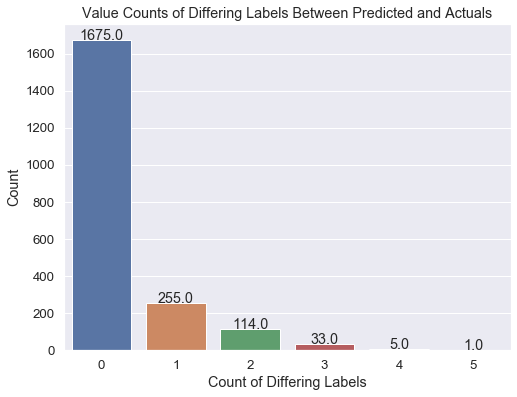

In [301]:
# Plot the value counts
# Create a bar plot using Seaborn

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=label_diff_value_counts.index, y=label_diff_value_counts.values)
plt.xlabel('Count of Differing Labels')
plt.ylabel('Count')
plt.title('Value Counts of Differing Labels Between Predicted and Actuals')

# Annotate the bars with value counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

In [304]:
#got help from chatgt to write this

# Define column names from y_test
column_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create a new column to store differing indexes and map them to column names
holdout_results_df['differing_indexes'] = holdout_results_df.apply(lambda row: [i for i, (pred, true) in enumerate(zip(row['multilabel_preds'], row['y_test'])) if pred != true], axis=1)
holdout_results_df['differing_columns'] = holdout_results_df['differing_indexes'].apply(lambda indexes: [column_names[i] for i in indexes])


In [305]:
def convert_list_to_string(lst):
    if isinstance(lst, list) and len(lst) > 0:
        return ', '.join(lst)
    else:
        return 'None'

In [306]:
holdout_results_df['differing_columns'] = holdout_results_df['differing_columns'].apply(convert_list_to_string)

In [307]:
differing_column_combos = holdout_results_df['differing_columns'].value_counts()[:10]

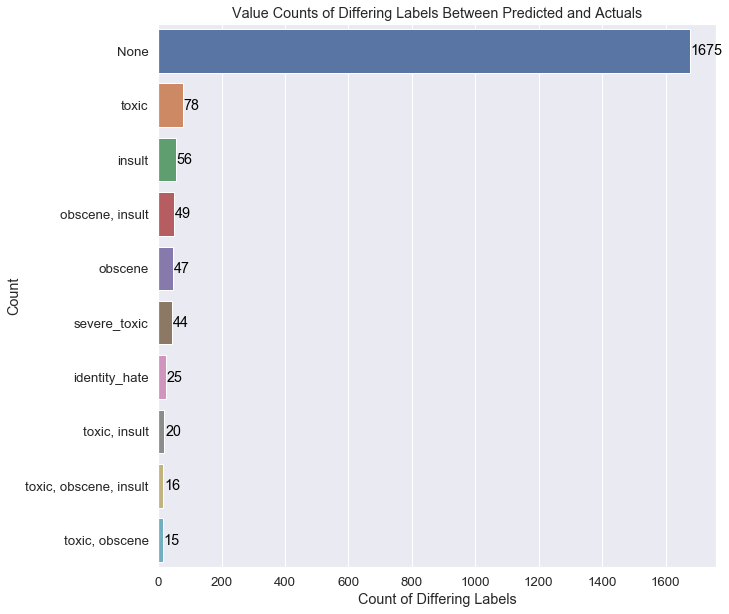

In [308]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(y=differing_column_combos.index, x=differing_column_combos.values, orient = 'h')
plt.xlabel('Count of Differing Labels')
plt.ylabel('Count')
plt.title('Value Counts of Differing Labels Between Predicted and Actuals')

# Annotate the bars with value counts
for i, v in enumerate(differing_column_combos):
    ax.text(v + 3, i, str(v), color='black', va='center')
plt.show()